## Stock Momentum Alerts PoC (Alpha Vantage MCP + GPT)

- Purpose: Detect sudden momentum changes and suggest actions (advisory only)
- Data: Alpha Vantage (historical for PoC), via MCP server or HTTP fallback
- AI: OpenAI GPT for concise suggestions; human makes final decision

Prereqs:
- Set `ALPHAVANTAGE_API_KEY` and optionally `OPENAI_API_KEY` in environment
- Respect Alpha Vantage free-tier limits (5 req/min, 500/day)

Notes:
- This PoC is not financial advice. Use at your own risk.


In [1]:
%pip install -q pandas numpy matplotlib requests openai python-dotenv



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import time
from dataclasses import dataclass
from typing import Optional, Dict, Any, Tuple

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv

# Inline plotting for notebooks
%matplotlib inline

# Load .env at startup (closest file wins)
load_dotenv(find_dotenv(usecwd=True))

ALPHAVANTAGE_API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
print(f"Using OpenAI model: {OPENAI_MODEL}")

if not ALPHAVANTAGE_API_KEY:
    print("Warning: ALPHAVANTAGE_API_KEY is not set. Put it in your .env file.")

@dataclass
class FetchConfig:
    symbol: str
    function: str = "TIME_SERIES_INTRADAY"
    interval: str = "5min"  # e.g., 1min, 5min, 15min, 30min, 60min
    outputsize: str = "compact"  # compact or full
    datatype: str = "json"

ALPHAVANTAGE_BASE_URL = "https://www.alphavantage.co/query"

# Optional: hypothetical MCP endpoint if available; we will fallback to HTTP
MCP_ALPHA_VANTAGE_URL: Optional[str] = os.getenv("MCP_ALPHA_VANTAGE_URL", "")  # e.g., https://mcp.alphavantage.co/mcp



Using OpenAI model: gpt-4o-mini


In [3]:
def fetch_alpha_vantage_http(cfg: FetchConfig) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    params = {
        "function": cfg.function,
        "symbol": cfg.symbol,
        "interval": cfg.interval,
        "outputsize": cfg.outputsize,
        "datatype": cfg.datatype,
        "apikey": ALPHAVANTAGE_API_KEY,
    }
    r = requests.get(ALPHAVANTAGE_BASE_URL, params=params, timeout=30)
    r.raise_for_status()
    payload = r.json()
    if "Error Message" in payload or "Note" in payload:
        raise RuntimeError(f"Alpha Vantage error: {payload.get('Error Message') or payload.get('Note')}")

    # Determine key from function
    key_map = {
        "TIME_SERIES_INTRADAY": f"Time Series ({cfg.interval})",
        "TIME_SERIES_DAILY": "Time Series (Daily)",
        "TIME_SERIES_DAILY_ADJUSTED": "Time Series (Daily)",
        "TIME_SERIES_WEEKLY": "Weekly Time Series",
        "TIME_SERIES_MONTHLY": "Monthly Time Series",
    }
    series_key = key_map.get(cfg.function)
    if series_key is None or series_key not in payload:
        # Best-effort: try find first dict-like time series
        series_key = next((k for k in payload.keys() if "Series" in k or "Time" in k), None)
    if series_key is None or series_key not in payload:
        raise RuntimeError("Unexpected Alpha Vantage response shape")

    ts = payload[series_key]
    df = pd.DataFrame.from_dict(ts, orient="index")
    # Standardize column names
    rename_map = {
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. volume": "volume",
    }
    df = df.rename(columns=rename_map)
    for col in [c for c in ["open", "high", "low", "close", "volume"] if c in df.columns]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    meta = payload.get("Meta Data", {})
    return df, meta


def try_fetch_alpha_vantage(cfg: FetchConfig) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    # Placeholder for MCP path: currently use HTTP directly
    return fetch_alpha_vantage_http(cfg)



In [4]:
def detect_momentum_events(df: pd.DataFrame,
                           price_col: str = "close",
                           pct_change_window: int = 1,
                           threshold_abs_pct: float = 0.02,
                           zscore_window: int = 50,
                           use_zscore: bool = True) -> pd.DataFrame:
    """
    Detect sudden momentum changes.
    - threshold_abs_pct: absolute percentage change threshold (e.g., 0.02 == 2%).
    - If use_zscore, also flag changes with z-score > 3 within rolling window.
    Returns a copy with added columns and boolean event flag.
    """
    if price_col not in df.columns:
        raise ValueError(f"price_col '{price_col}' not in df")

    data = df.copy()
    data = data.sort_index()
    data["return_pct"] = data[price_col].pct_change(pct_change_window)
    data["abs_return_pct"] = data["return_pct"].abs()

    event_flag = data["abs_return_pct"] > threshold_abs_pct

    if use_zscore:
        rolling_std = data["return_pct"].rolling(zscore_window, min_periods=max(5, zscore_window // 5)).std()
        rolling_mean = data["return_pct"].rolling(zscore_window, min_periods=max(5, zscore_window // 5)).mean()
        z = (data["return_pct"] - rolling_mean) / (rolling_std.replace(0, np.nan))
        data["return_zscore"] = z
        z_flag = z.abs() > 3
        event_flag = event_flag | z_flag
    else:
        data["return_zscore"] = np.nan

    data["momentum_event"] = event_flag.fillna(False)
    data["direction"] = np.where(data["return_pct"] > 0, "up", np.where(data["return_pct"] < 0, "down", "flat"))

    return data



In [5]:
from typing import List

try:
    from openai import OpenAI
except Exception:
    OpenAI = None


def suggest_actions_with_gpt(events_df: pd.DataFrame,
                             symbol: str,
                             max_events: int = 10) -> List[Dict[str, Any]]:
    if OpenAI is None or not OPENAI_API_KEY:
        print("Note: OPENAI_API_KEY not set or OpenAI client not available. Skipping AI suggestions.")
        results = []
        subset = events_df[events_df["momentum_event"]].tail(max_events)
        for ts, row in subset.iterrows():
            results.append({
                "timestamp": ts,
                "symbol": symbol,
                "direction": row.get("direction"),
                "return_pct": row.get("return_pct"),
                "suggestion": "Review event. Consider risk management; this is not advice.",
            })
        return results

    client = OpenAI(api_key=OPENAI_API_KEY)

    outputs: List[Dict[str, Any]] = []
    subset = events_df[events_df["momentum_event"]].tail(max_events)
    for ts, row in subset.iterrows():
        direction = row.get("direction")
        ret = row.get("return_pct")
        prompt = (
            f"You are an assistant for a trader. A sudden momentum event occurred for {symbol}.\n"
            f"Timestamp: {ts} (UTC). Direction: {direction}. One-interval return: {ret:.4f} ({ret*100:.2f}%).\n"
            "Provide a concise 1-2 sentence advisory suggestion with risk management reminders. Do not provide financial advice."
        )
        try:
            resp = client.chat.completions.create(
                model=OPENAI_MODEL,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=120,
                temperature=0.2,
            )
            suggestion = resp.choices[0].message.content.strip()
        except Exception as e:
            suggestion = f"Suggestion unavailable ({e})."
        outputs.append({
            "timestamp": ts,
            "symbol": symbol,
            "direction": direction,
            "return_pct": ret,
            "suggestion": suggestion,
        })
    return outputs



In [6]:
def plot_price_with_events(df: pd.DataFrame,
                           symbol: str,
                           price_col: str = "close") -> None:
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[price_col], label=f"{symbol} {price_col}", color="#1f77b4")
    events = df[df["momentum_event"]]
    if not events.empty:
        plt.scatter(events.index, events[price_col], color="#d62728", label="momentum event", zorder=5)
    plt.title(f"{symbol} price with momentum events")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


def print_alerts(suggestions: list) -> None:
    for item in suggestions:
        ts = item["timestamp"]
        sym = item["symbol"]
        direction = item["direction"]
        ret = item["return_pct"]
        sugg = item["suggestion"]
        print(f"[{ts}] {sym} momentum {direction}, return {ret*100:.2f}% -> {sugg}")



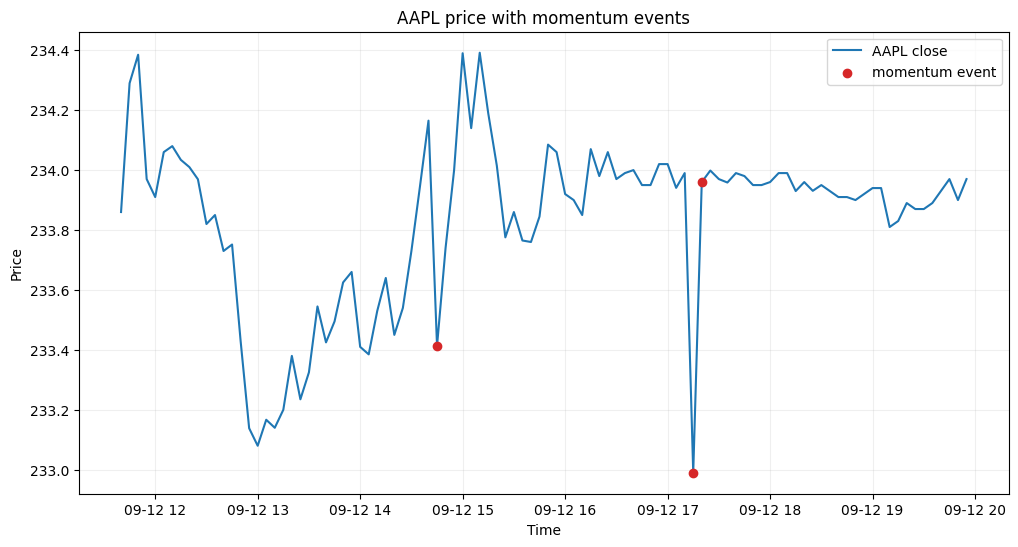

[2025-09-12 14:45:00] AAPL momentum down, return -0.32% -> Suggestion unavailable (Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-xTydp***************************************xnCG. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}).
[2025-09-12 17:15:00] AAPL momentum down, return -0.43% -> Suggestion unavailable (Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-xTydp***************************************xnCG. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}).
[2025-09-12 17:20:00] AAPL momentum up, return 0.42% -> Suggestion unavailable (Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-xTydp***************************************xnCG. You can find your API key at https://platform.openai.com/account/api-keys.', '

In [7]:
symbol = "AAPL"  # change as needed
cfg = FetchConfig(symbol=symbol, function="TIME_SERIES_INTRADAY", interval="5min", outputsize="compact")

try:
    price_df, meta = try_fetch_alpha_vantage(cfg)
    enriched = detect_momentum_events(price_df, price_col="close", threshold_abs_pct=0.02, zscore_window=50)
    suggestions = suggest_actions_with_gpt(enriched, symbol=symbol, max_events=8)
    plot_price_with_events(enriched, symbol=symbol, price_col="close")
    print_alerts(suggestions)
except Exception as e:
    print("Run failed:", e)
    if "Note" in str(e):
        print("Likely hit API rate limits; try again after a minute or switch to 'outputsize=full' with daily data.")

